# Clustering (apprentissage non-supervisé)

Pour de nombreux problèmes, il existe des bases de données volumineuses, mais non annotées. Dans ce cas, on souhaite souvent trouver une partition des données qui donne des groupes homogènes. Il existe de nombreux algorithmes de partitionnement de données (*clustering* en anglais) qui utilisent des critères différents d'*homogénéité* et qui, généralement, laisse le choix du nombre de groupes (appelés *clusters*) à l'utilisateur. 

L'objectif de ce TP est de se familiariser avec les principaux algorithmes de clustering, et des critères qui permettent de sélectionner le nombre de clusters (puisqu'en l'absence d'annotations, on ne peut sélectionner les hyper-paramètres par validation croisée).

Crédit : notebook inspiré d'un TP de Nicolas Enjalbert Courrech (INRAE, MIAT Toulouse).

### Notations

Soit la matrice de données $X \in \mathbb{R}^{n \times p}$ exprimant $p$ variables pour $n$ individus. Le but est de trouver une partition $P = \{P_1, \ldots, P_K\}$ des $n$ individus où $P_k \subset P$ est l'ensemble des individus du groupe $k$. On note $\mu_k \in \mathbb{R}^p$ le barycentre des individus contenus dans le groupe $k$ tels que $\forall k \in \{1, ..., K\}, \mu_k = \frac{1}{n_k} \sum_{i \in P_k} X_{i,\cdot}$ avec $n_k = |P_k|$ et $X_{i,\cdot}$ la $i$-eme ligne de la matrice $X$.

### Librairies utilisées

Dans ce TP, on utilisera les librairies `pandas` et `numpy` pour la lecture et le pré-traitement des données, `sklearn` et `scipy` pour l'implémentation et l'interprétation des algorithmes de clustering, et `matplotlib` pour la visualisation des données et des résultats.

In [22]:
import pandas as pd 
import numpy as np 

import sklearn
from sklearn import decomposition
from sklearn import cluster
from sklearn import metrics

from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

### Préparation du jeu de données 

Nous allons utiliser les données Iris de Fisher. Notez que les annotations / variables à expliquer (*i.e.*, les espèces d'Iris) vont être utiles pour la visualisation des données et l'interprétation des résultats, mais qu'elles ne seront jamais utilisées par les algorithmes de clustering. 

In [2]:
# Credits: https://www.angela1c.com/projects/iris_project/downloading-iris/
csv_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
# using the attribute information as the column names
col_names = ['Sepal_Length','Sepal_Width','Petal_Length','Petal_Width','Species']
iris =  pd.read_csv(csv_url, names = col_names)
iris

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
y_true = iris[["Species"]]
y_true

,Species
0,Iris-setosa
1,Iris-setosa
2,Iris-setosa
3,Iris-setosa
4,Iris-setosa
...,...
145,Iris-virginica
146,Iris-virginica
147,Iris-virginica
148,Iris-virginica


On simule un jeu de données non annotées.

In [4]:
X = iris.drop(["Species"], axis = 1)
X

,Sepal_Length,Sepal_Width,Petal_Length,Petal_Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


On utilise une analyse en composantes principales (ACP) pour réduire la dimension des données, ce qui facilite leur visualisation. On verra comment fonctionne l'ACP dans un autre TP.

In [5]:
pca = decomposition.PCA(n_components = 2)
pca_X = pca.fit_transform(X)

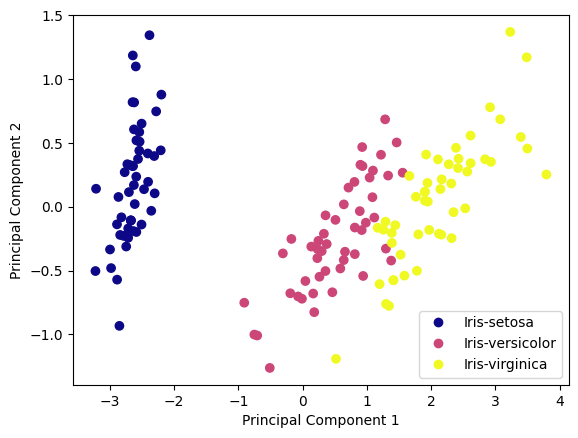

In [6]:
classes = np.unique(y_true)
str2int = dict((k, v) for (v, k) in enumerate(classes))
colors =  np.vectorize(
#  TODO 
)

fig, ax = plt.subplots()
scatter = plt.scatter(pca_X[:, 0], pca_X[:, 1], c=colors, cmap='plasma')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=scatter.legend_elements()[0], 
           labels=list(classes))
plt.show()

## 1. Algorithmes de clustering

### 1.1 K-means
#### 1.1.1. K-means "à la main"

Reprenez le cours pour compléter les fonctions suivantes, nécessaires à l'implémentation de l'algorithme des K-moyennes.

In [19]:
def plot_data(data, labels, fontsize=15):
    """
    Affichage en deux dimensions de données
    Args:
        - data (np.ndarray): données à visualiser
        - labels (list): nom des caractéristiques
        - fontsize (int): taille de la police
    """
    _, ax = plt.subplots()
    #  TODO 
    ax.set_xlabel(labels[0], fontsize=fontsize)
    ax.set_ylabel(labels[1], fontsize=fontsize)
    plt.title('Données IRIS', fontsize=fontsize)
    return ax

In [20]:
def init_centroids(data, K=3):
    """
    Initialisation des centres des classes.
    Args:
        - data (np.ndarray) : les données de dimension (n, p) 
        où n est le nombre d'échantillons et p leur dimension
        - K (int) : le nombre de classes.
    """
    #  TODO 

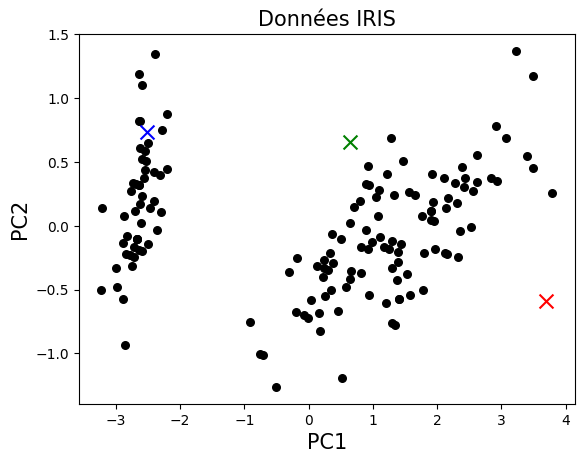

In [21]:
K = 3
colors = ['red', 'blue', 'green']

centroids = init_centroids(pca_X, K=3)
ax = plot_data(pca_X, ['PC1', 'PC2'])

for class_id in range(centroids.shape[0]):
    ax.scatter(centroids[class_id, 0], centroids[class_id, 1], color=colors[class_id], s=100, marker='x')

In [23]:
def update_responsabilities_km(data, centroids):
    """
    Mise à jour des responsabilités
    Args:
        - data (np.ndarray) : les données de dimension (N, D) 
        où N est le nombre d'échantillons et D leur dimension
        - K (int) : le nombre de classes.
    """
    #  TODO 
    
    N = classes.shape[0]
    K = len(np.unique(classes))
    responsabilities = np.stack(
        [classes == class_id for class_id in np.unique(classes)]
    )
    responsabilities = responsabilities.T
    
    assert responsabilities.shape == tuple((N, K))
    assert (np.sum(responsabilities, axis=1) == 1).all()
    
    return classes, responsabilities

def plot_update_km(data, classes, centroids, km_loss=None, colors=None, it=0, fontsize=15, marker_size=100):
    """
    Affichage des données avec les centres des classes.
    Args:
        - data (np.ndarray) : les données (N x D)
        - classes (np.ndarray) : les classes (N x 1)
        - centroids (np.ndarray) : les centres des classes (K x D)
        - km_loss (float) : la valeur de la fonction objective
        - colors (list) : une liste de couleurs de longueur K
        - it (int) : l'itération de l'algorithme
        - fontsize (int) : la taille de la police
    """
    _, ax = plt.subplots()

    n_classes = len(np.unique(classes))
    if colors is None:
        colors = plt.cm.get_cmap('hsv', n_classes+1)
        colors = [colors(i) for i in range(1, n_classes+1)]
        
    for class_id in np.unique(classes):
        #  TODO 
        
    if km_loss is None:
        plt.title('Itération {:3d} - Mise à jour des classes'.format(it))
    else:
        plt.title('Itération {:3d} - Mise à jour des classes - Fonction objective = {:.2f}'.format(it, km_loss))
    plt.show()

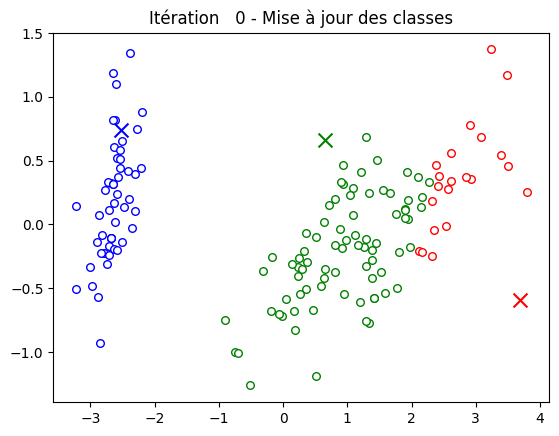

In [25]:
classes, responsabilities = update_responsabilities_km(pca_X, centroids)
plot_update_km(pca_X, classes, centroids, colors=colors)

In [26]:
def update_centroids(data, responsabilities):
    """
    Mise à jour des centres des classes.
    Args:
        - data (np.ndarray) : les données (N x D)
        - responsabilities (np.ndarray) : les responsabilités (N, K)
    """
    N, D = data.shape
    K = responsabilities.shape[1]

    #  TODO 
    
    assert centroids.shape == tuple((K, D))
    return centroids

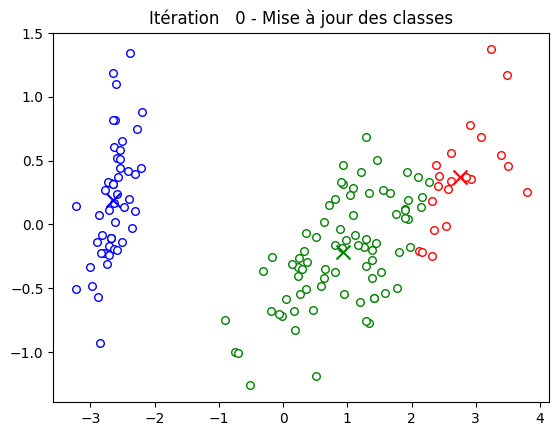

In [28]:
centroids = update_centroids(pca_X, responsabilities)
plot_update_km(pca_X, classes, centroids, colors=colors)

In [35]:
def km_loss(data, classes, centroids):
    """
    Fonction objective de l'algorithme des K-moyennes
    Args:
        - data (np.ndarray) : les données (N x D)
        - classes (np.ndarray) : les classes (N x 1)
        - centroids (np.ndarray) : les centres des classes (K x D)
    """
    loss = 0
    for class_id in np.unique(classes):
        #  TODO 
    return loss
    
def run_k_means(data, K, colors=None, eps=1e-2, max_it=5, plot=True):
    """
    Execute l'algorithme des K-moyennes.
    Args:
        - data (np.ndarray) : les données de dimension (N x D) 
        - K (int) : le nombre de classes
        - colors (list) : une liste de couleurs de longueur K
        - eps (float) : tolérance pour le critère d'arrêt de l'algorithme
        - max_it (int) : nombre maximal d'itérations
        - plot (boolean) : affichage ou non des données et des centres
    """
    if colors is None:
        colors = plt.cm.get_cmap('hsv', K+1)
        colors = [colors(i) for i in range(1, K+1)]
        
    centroids = init_centroids(data, K)
    diff = np.inf
    it = 0
    loss_hist = []
    while diff > eps and it < max_it:
        classes, responsabilities = update_responsabilities_km(data, centroids)
        
        loss = km_loss(data, classes, centroids)
        loss_hist.append(loss)
        
        if plot:
            plot_update_km(data, classes, centroids, loss, colors, it)
        
        new_centroids = update_centroids(data, responsabilities)
        diff = np.mean(np.sqrt(np.sum((centroids - new_centroids)**2)))
        centroids = new_centroids
        
        if plot:
            plot_update_km(data, classes, centroids, loss, colors, it)
        
        loss = km_loss(data, classes, centroids)
        loss_hist.append(loss)
        it += 1

    return loss_hist, centroids, responsabilities, classes

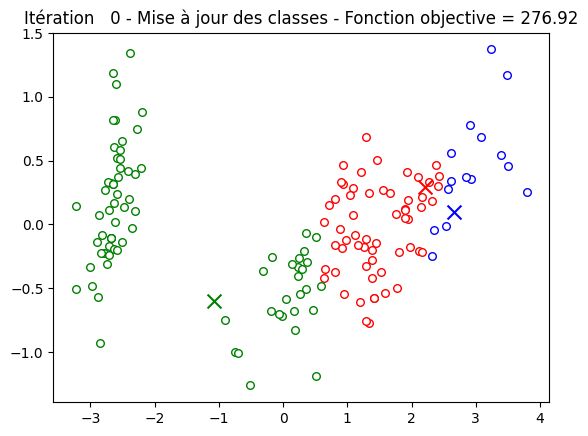

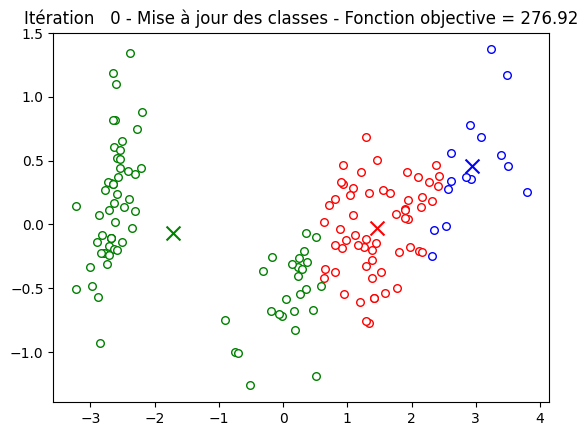

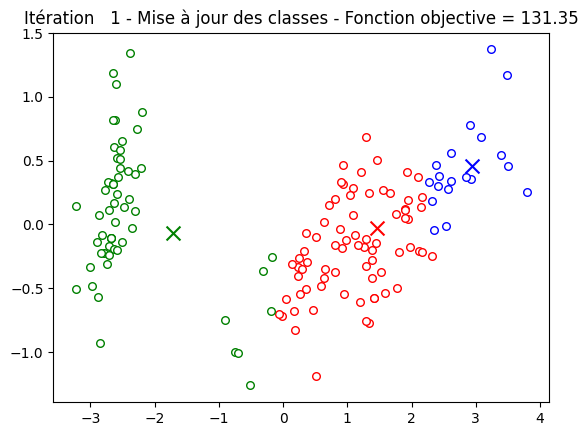

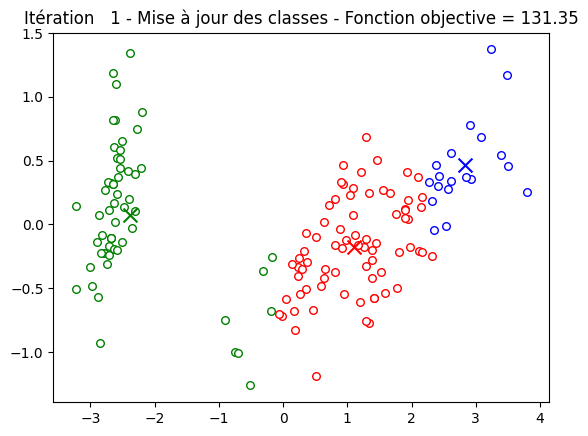

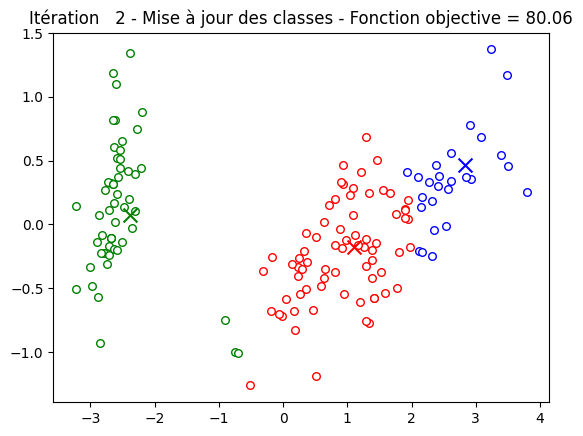

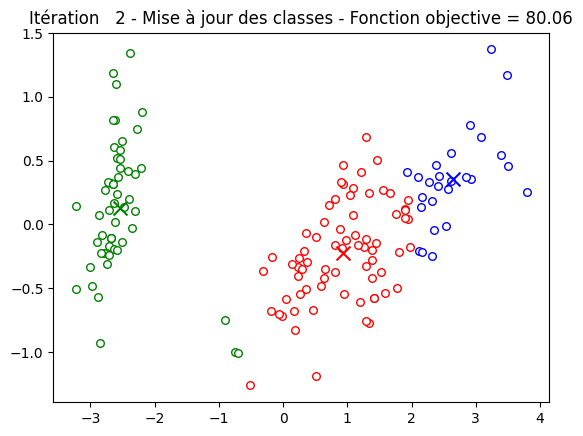

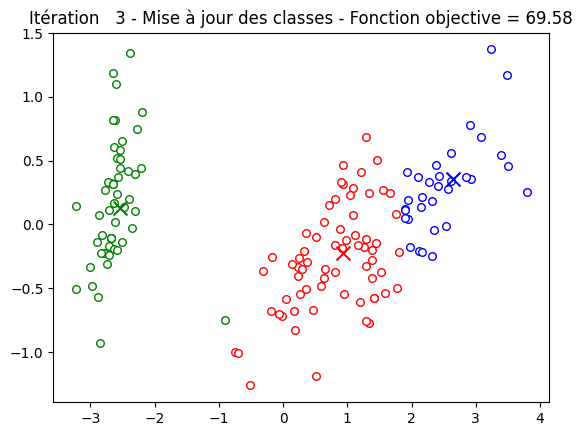

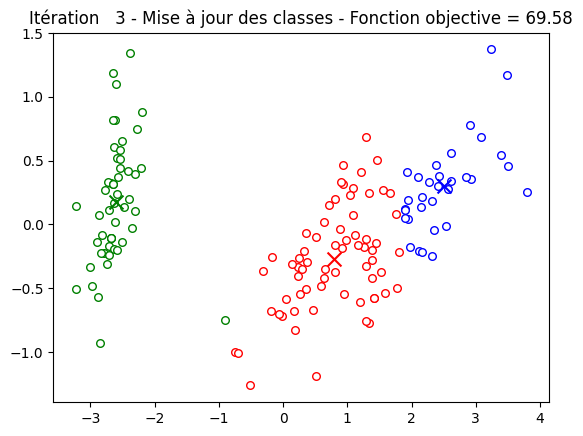

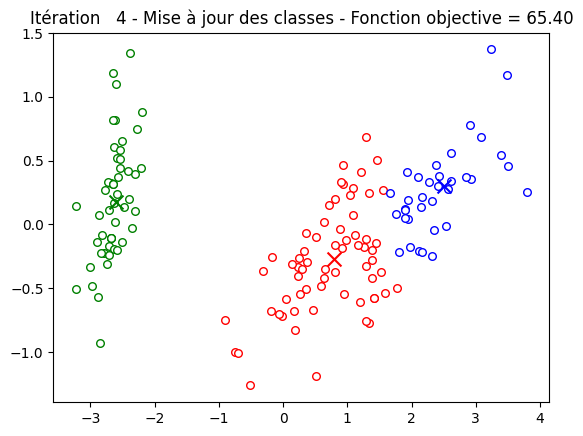

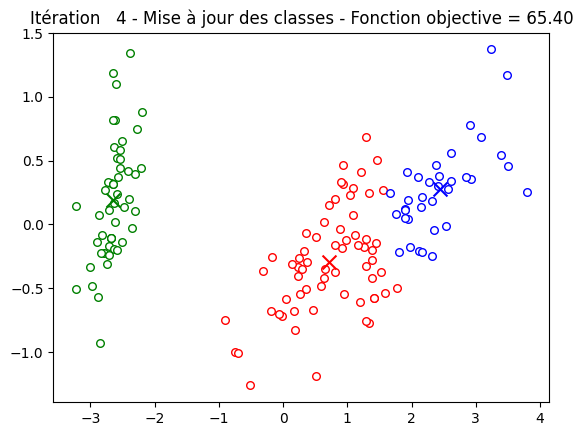

In [36]:
loss_hist, centroids, responsabilities, classes = run_k_means(pca_X, K, colors)

#### 1.1.2. K-means avec sklearn

Maintenant, utilisez la classe `sklearn.cluster.KMeans` pour catégoriser les données pour $K \in \{2, \ldots, 11\}$ clusters. Visualisez les clusters obtenus en utilisant la projection sur les deux premières composantes principales. Intuitivement, quel clustering vous semble-t-il le meilleur ? Sur quels critères vous basez vous ?

In [ ]:
clusters = {
    'kmeans': {},
    'hier': {},
    'dbscan': {}
}

In [ ]:
#  TODO 

In [ ]:
n_rows = 2
n_cols = n_clustering // n_rows
fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 10))
#  TODO 
plt.show()

### 1.2 Clustering Hierarchique Ascendant

Le clustering hiérarchique ascendant est un algorithme de clustering dont le nombre de clusters diminue à chaque itération. A l'initialisation, le nombre de clusters $K$ est égal au nombre de données $n$. Ainsi, toutes les données appartiennent à des clusters différents. A chaque itération, les clusters sont fusionnés selon un critère de similarité. A l'itération $t$, il y a donc $n - t$ clusters. L'algorithme s'arrête lorsque toutes les données appartiennent à un seul cluster.

Utilisez la classe `sklearn.cluster.AgglomerativeClustering` pour catégoriser les données de manière hiérarchique avec `n_clusters=None` et `distance_threshold=0`. 

Les clusters sont centenus dans l'attribut `labels_` : sont-ils informatifs ? Recommencez en augmentant la `distance_threshold`. Comment choisir cette distance ? Le choix de la distance est-il équivalent au choix du nombre de clusters ?

Utilisez à nouveau `distance_threshold=0` : que contiennent les attributs `children_` et `distances_` ? Comment évoluent les distances au cours des itérations ?

In [ ]:
#  TODO 

In [ ]:
#  TODO 

In [ ]:
#  TODO 

In [ ]:
fig = plt.figure()
#  TODO 
plt.ylabel('Distance entre les clusters fusionnés')
plt.show()

Un très bon outil de visualisation et d'aide à la décision est le dendogramme. Un dendogramme est un diagramme qui illustre l'arrangement des clusters. Il permet de visusaliser l'ascendance des clusters, et la distance entre les clusters fusionnés.

In [ ]:
# Crédit : https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [ ]:
#  TODO 

In [ ]:
#  TODO 

Testez la méthode de clustering hiérarchique pour 3 clusters et d'autres critères de similarité.

In [ ]:
k = 3

for linkage in ['ward', 'average', 'complete', 'single']:
    cl = cluster.AgglomerativeClustering(n_clusters=k, linkage=linkage).fit(X)
    clusters['hier'][linkage] = cl

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

#  TODO 

plt.show()

### 1.3 DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN est un algorithme de clustering basé sur la spacialité qui cherche à trouver des zones à forte densité séparées par des zones à faible densité. La recherche se fait de proche en proche en parcourant une boule de rayon `eps` centrée sur les données. Si aucun voisin n'est inclus dans la boule, alors la zone courante est considérée comme une zone à faible densité, et aucun cluster n'est attribué à la donnée (cluster -1 dans `sklearn.cluster.DBSCAN`).

Utilisez `sklearn.cluster.DBSCAN` pour différentes tailles de voisinage. Que se passe-t-il quand la taille est trop petite ? Trop grande ?

In [ ]:
#  TODO 

In [ ]:
n_rows = 2
n_cols = n_clustering // n_rows

norm = Normalize(vmin=-1, vmax=3)

fig, ax = plt.subplots(n_rows, n_cols, figsize=(15, 10))
for i, dbscan_clusters in enumerate(clusters['dbscan'].values()):
    ax[i // n_cols, i % n_cols].scatter(pca_X[:, 0], pca_X[:, 1], c=dbscan_clusters.labels_,  cmap='plasma', norm=norm)
plt.show()

Représentez le nombre de données par cluster avec un histogramme.

In [ ]:
#  TODO 

## 2. Sélection de modèle 

Comment sélectionner les hyper-paramètres des algorithmes de clustering, qui conditionnent le nombre de clusters ? Prenons l'exemple des K-moyennes. Cela a-t-il du sens de sélectionner le nombre de clusters qui minimise la fonction objective (l'inertie intra-classe) ? Faites un graphe de l'inertie intra-classe (voir l'attribut `inertia_` de `sklearn.cluster.KMeans`) en fonction du nombre de clusters.

In [ ]:
#  TODO 

### 2.1 Silhouette

Le coefficient de la Silhouette mesure l'homogénéité des clusters : sont-ils bien regroupés et éloignés des autres ? Pour les K-moyennes, puis pour chaque méthode de clustering, comparer le coefficient de la silhouette afin de sélectionner le modèle avec le meilleur résultat.

In [ ]:
#  TODO 
        else:
            #  TODO 

In [ ]:
def plot_hist(score_dict):
    labels = list(score_dict['kmeans'].keys()) + list(score_dict['hier'].keys()) + list(score_dict['dbscan'].keys())
    x = np.arange(len(labels))
    values = []
    colors = []
    for cluster_name in score_dict:
        score_values = [score_dict[cluster_name][k] for k in score_dict[cluster_name]]
        values.extend(score_values)
        
        # Assign colors by cluster type
        if cluster_name == 'kmeans':
            colors.extend(['blue'] * len(score_values))
        elif cluster_name == 'hier':
            colors.extend(['orange'] * len(score_values))
        elif cluster_name == 'dbscan':
            colors.extend(['green'] * len(score_values))
    
    fig, ax = plt.subplots(figsize=(15, 6))
    bars = ax.bar(x, values, color=colors)
    
    # Customize x-axis
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45, ha='right')
    
    # Add legend
    ax.legend(handles=[
        plt.Rectangle((0,0),1,1, color='blue', label='K-means'),
        plt.Rectangle((0,0),1,1, color='orange', label='Hierarchical'),
        plt.Rectangle((0,0),1,1, color='green', label='DBSCAN')
    ], loc='upper right', fontsize=15)
    
    # Add labels and title
    ax.set_ylabel('Score')
    plt.tight_layout()
    return ax

In [ ]:
ax = plot_hist(silhouette)
ax.set_title('Silhouette Score by Method and Parameters')
plt.show()

### 2.2 Davies Bouldin Score

Le score de Davies Bouldin mesure pour chaque cluster sa similarité avec le cluster le plus proche, mesuré comme le ratio de l'inertie intra-classe sur l'inertie inter-classe.

In [ ]:
dbscore = {}
for cluster_name in clusters.keys():
    dbscore[cluster_name] = {}
    for cluster_param, cluster in clusters[cluster_name].items():
        if len(np.unique(cluster.labels_)) > 1:
            #  TODO 
        else:
            #  TODO 

In [ ]:
ax = plot_hist(dbscore)
ax.set_title('Davies Bouldin Score by Method and Parameters')
plt.show()

### 2.3 Table de contingence

La table de contingence est un outil statistique simple qui permet de voir rapidement si les individus sont classé dans la même classe entre deux partitions. Deux partitions similaires donneront une matrice diagonale. La table de contingence peut donc être utile pour comparer deux algorithmes de clustering. Néanmoins, sans annotation, elle ne permet pas de sélectionner les hyper-paramètres. 

In [ ]:
print("Nb clusters kmeans: ", len(np.unique(clusters['kmeans']['k=2'].labels_)))
print("Nb clusters hierarchical clustering: ", len(np.unique(clusters['hier']['ward'].labels_)))

#  TODO 
contingency

### 2.4 Indice de Rand

L'indice de Rand est un score qui permet de mesurer la similitude entre deux partitions. Notons $P_1$ et $P_2$ deux partitions des données désignées par leur indice $i \in \{1, \ldots, n\}$. Pour calculer l'indice de Rand, on calcule le nombre $a$, $b$, $c$, et $d$ de paires d'éléments $(i,j)$ qui sont : 
* dans le même groupe dans $P_1$ et le même groupe dans $P_2$,
* dans le même groupe dans $P_1$ et dans un groupe différent dans $P_2$,
* dans un groupe différent dans $P_1$ et le même groupe dans $P_2$,
* dans un groupe différent dans $P_1$ et dans un groupe différent dans $P_2$, respectivement.

L'indice de Rand est alors $$ RI = \frac{a+d}{a+b+c+d}.$$

Par rapport à la table de contigence, quel est l'avantage de cette métrique ?

In [ ]:
rand_score = {}
for cluster_name in clusters.keys():
    rand_score[cluster_name] = {}
    for cluster_param, cluster in clusters[cluster_name].items():
        #  TODO 

In [ ]:
ax = plot_hist(rand_score)
ax.set_title('Rand Score by Method and Parameters')
plt.show()

Les critères de sélection s'accordent-ils ?

In [1]:
###  TODO )"," TODO ",\
    txt, flags=re.DOTALL))
f2.close()

### </CORRECTION> ###